

# Bitcoin Price Prediction

The goal of this case study is tu use classification based models to predict whether the current signal is **buy or sell** depending on the short term vs long term price.

## Content

* [1. Problem Definition](#0)
* [2. Getting Started - Load Libraries and Dataset](#1)
    * [2.1. Load Libraries](#1.1)    
    * [2.2. Load Dataset](#1.2)
* [3. Exploratory Data Analysis](#2)
    * [3.1 Descriptive Statistics](#2.1) 
* [4. Data Preparation](#3)
    * [4.1 Data Cleaning](#3.1)
    * [4.2. Preparing classification data](#3.2)
    * [4.3. Feature Engineering-Constructing Technical Indicators](#3.3)
    * [4.4.Data Visualisation](#3.4)
* [5.Evaluate Algorithms and Models](#4)        
    * [5.1. Train/Test Split](#4.1)
    * [5.2. Test Options and Evaluation Metrics](#4.2)
    * [5.3. Compare Models and Algorithms](#4.3) 
* [6. Model Tuning and Grid Search](#5)  
* [7. Finalize the Model](#6)  
    * [7.1. Results on test dataset](#6.1)
    * [7.1. Variable Intuition/Feature Selection](#6.2) 
* [8. Backtesting](#7)     


<a id='0'></a>
# 1. Problem Definition

The problem of predicting a buy or sell signal for a trading strategy is defined in the
classification framework, where the predicted variable has a value of 1 for buy and 0
for sell.

The buy or sell signal are decided on the basis on the comparison of short term vs. long
term price.

For the purpose of presented case study, we get the data from one of the largest Bit‐
coin exchanges in terms of average daily volume traded—Bitstamp (https://
www.bitstamp.com). Data can be found at: https://www.kaggle.com/mczielinski/bitcoin-historical-data

<a id='1'></a>
# 2. Getting Started- Loading the data and python packages

<a id='1.1'></a>
## 2.1. Loading the python packages

In [1]:
# Load libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas import read_csv, set_option
from pandas.plotting import scatter_matrix
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

#Libraries for Deep Learning Models
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.optimizers import SGD


Using TensorFlow backend.


<a id='1.2'></a>
## 2.2. Loading the Data

#### <font color='red'>Note : Due to limit in the github for the data size, a sample of the data has been loaded in the jupyter notebook repository of this book. However, all the subsequent results in this jupyter notebook is with actual data (~150MB) under https://www.kaggle.com/mlfinancebook/bitstamp-bicoin-minutes-data. You should load the full data in case you want to reproduce the results. </font> 

In [2]:
# load dataset
dataset = pd.read_csv('BitstampData_sample.csv')

In [3]:
#Diable the warnings
import warnings
warnings.filterwarnings('ignore')

<a id='2'></a>
# 3. Exploratory Data Analysis

<a id='2.1'></a>
## 3.1. Descriptive Statistics

In [4]:
# shape
dataset.shape

(2841377, 8)

In [5]:
# peek at data
set_option('display.width', 100)
dataset.tail(5)

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
2841372,1496188560,2190.49,2190.49,2181.37,2181.37,1.700166,3723.784755,2190.247337
2841373,1496188620,2190.50,2197.52,2186.17,2195.63,6.561029,14402.811961,2195.206304
2841374,1496188680,2195.62,2197.52,2191.52,2191.83,15.662847,34361.023647,2193.791712
2841375,1496188740,2195.82,2216.00,2195.82,2203.51,27.090309,59913.492565,2211.620837
2841376,1496188800,2201.70,2209.81,2196.98,2208.33,9.961835,21972.308955,2205.648801


In [6]:
# describe data
set_option('precision', 3)
dataset.describe()

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
count,2.841e+06,1.651e+06,1.651e+06,1.651e+06,1.651e+06,1.651e+06,1.651e+06,1.651e+06
mean,1.411e+09,4.959e+02,4.962e+02,4.955e+02,4.959e+02,1.188e+01,5.316e+03,4.959e+02
std,4.938e+07,3.642e+02,3.645e+02,3.639e+02,3.643e+02,4.094e+01,1.998e+04,3.642e+02
min,1.325e+09,3.800e+00,3.800e+00,1.500e+00,1.500e+00,0.000e+00,0.000e+00,3.800e+00
25%,1.368e+09,2.399e+02,2.400e+02,2.398e+02,2.399e+02,3.828e-01,1.240e+02,2.399e+02
50%,1.411e+09,4.200e+02,4.200e+02,4.199e+02,4.200e+02,1.823e+00,6.146e+02,4.200e+02
75%,1.454e+09,6.410e+02,6.417e+02,6.402e+02,6.410e+02,8.028e+00,3.108e+03,6.410e+02
max,1.496e+09,2.755e+03,2.760e+03,2.752e+03,2.755e+03,5.854e+03,1.866e+06,2.754e+03


<a id='3'></a>
# 4. Data Preparation

<a id='3.1'></a>
## 4.1. Data Cleaning

In [7]:
#Checking for any null values and removing the null values'''
print('Null Values =',dataset.isnull().values.any())

Null Values = True


Given that there are null values, we need to clean the data by filling the *NaNs* with the last available values. 

In [8]:
dataset[dataset.columns.values] = dataset[dataset.columns.values].ffill()

In [9]:
dataset=dataset.drop(columns=['Timestamp'])

<a id='3.2'></a>
## 4.2. Preparing the data for classification

We attach a label to each movement: 
* **1** if the signal is that short term price will go up as compared to the long term. 
* **0** if the signal is that short term price will go down as compared to the long term.

In [10]:
# Initialize the `signals` DataFrame with the `signal` column
#datas['PriceMove'] = 0.0

# Create short simple moving average over the short window
dataset['short_mavg'] = dataset['Close'].rolling(window=10, min_periods=1, center=False).mean()

# Create long simple moving average over the long window
dataset['long_mavg'] = dataset['Close'].rolling(window=60, min_periods=1, center=False).mean()

# Create signals
dataset['signal'] = np.where(dataset['short_mavg'] > dataset['long_mavg'], 1.0, 0.0)

In [11]:
dataset.tail()

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,short_mavg,long_mavg,signal
2841372,2190.49,2190.49,2181.37,2181.37,1.700,3723.785,2190.247,2179.259,2189.616,0.0
2841373,2190.50,2197.52,2186.17,2195.63,6.561,14402.812,2195.206,2181.622,2189.877,0.0
2841374,2195.62,2197.52,2191.52,2191.83,15.663,34361.024,2193.792,2183.605,2189.943,0.0
2841375,2195.82,2216.00,2195.82,2203.51,27.090,59913.493,2211.621,2187.018,2190.204,0.0
2841376,2201.70,2209.81,2196.98,2208.33,9.962,21972.309,2205.649,2190.712,2190.510,1.0


<a id='3.3'></a>
## 4.3. Feature Engineering

We begin by the constructing a dataset that contains the predictors which will be used to make the predictions, and the output variable.

The current Data of the bicoin consists of date, open, high, low, close and Volume. Using this data we calculate the following  technical indicators:
* **Moving Average** : A moving average provides an indication of the trend of the price movement by cut down the amount of "noise" on a price chart. 
* **Stochastic Oscillator %K and %D** : A stochastic oscillator is a momentum indicator comparing a particular closing price of a security to a range of its prices over a certain period of time. %K and %D are slow and fast indicators.
* **Relative Strength Index(RSI)** :It is a momentum indicator that measures the magnitude of recent price changes to evaluate overbought or oversold conditions in the price of a stock or other asset. 
* **Rate Of Change(ROC)**: It is a momentum oscillator, which measures the percentage change between the current price and the n period past price. 
* **Momentum (MOM)** : It is the rate of acceleration of a security's price or volume – that is, the speed at which the price is changing.

In [12]:
#calculation of exponential moving average
def EMA(df, n):
    EMA = pd.Series(df['Close'].ewm(span=n, min_periods=n).mean(), name='EMA_' + str(n))
    return EMA
dataset['EMA10'] = EMA(dataset, 10)
dataset['EMA30'] = EMA(dataset, 30)
dataset['EMA200'] = EMA(dataset, 200)
dataset.head()

#calculation of rate of change
def ROC(df, n):  
    M = df.diff(n - 1)  
    N = df.shift(n - 1)  
    ROC = pd.Series(((M / N) * 100), name = 'ROC_' + str(n))   
    return ROC
dataset['ROC10'] = ROC(dataset['Close'], 10)
dataset['ROC30'] = ROC(dataset['Close'], 30)

#Calculation of price momentum
def MOM(df, n):   
    MOM = pd.Series(df.diff(n), name='Momentum_' + str(n))   
    return MOM
dataset['MOM10'] = MOM(dataset['Close'], 10)
dataset['MOM30'] = MOM(dataset['Close'], 30)

#calculation of relative strength index
def RSI(series, period):
 delta = series.diff().dropna()
 u = delta * 0
 d = u.copy()
 u[delta > 0] = delta[delta > 0]
 d[delta < 0] = -delta[delta < 0]
 u[u.index[period-1]] = np.mean( u[:period] ) #first value is sum of avg gains
 u = u.drop(u.index[:(period-1)])
 d[d.index[period-1]] = np.mean( d[:period] ) #first value is sum of avg losses
 d = d.drop(d.index[:(period-1)])
 rs = u.ewm(com=period-1, adjust=False).mean() / \
 d.ewm(com=period-1, adjust=False).mean()
 return 100 - 100 / (1 + rs)
dataset['RSI10'] = RSI(dataset['Close'], 10)
dataset['RSI30'] = RSI(dataset['Close'], 30)
dataset['RSI200'] = RSI(dataset['Close'], 200)

#calculation of stochastic osillator.

def STOK(close, low, high, n): 
 STOK = ((close - low.rolling(n).min()) / (high.rolling(n).max() - low.rolling(n).min())) * 100
 return STOK

def STOD(close, low, high, n):
 STOK = ((close - low.rolling(n).min()) / (high.rolling(n).max() - low.rolling(n).min())) * 100
 STOD = STOK.rolling(3).mean()
 return STOD

dataset['%K10'] = STOK(dataset['Close'], dataset['Low'], dataset['High'], 10)
dataset['%D10'] = STOD(dataset['Close'], dataset['Low'], dataset['High'], 10)
dataset['%K30'] = STOK(dataset['Close'], dataset['Low'], dataset['High'], 30)
dataset['%D30'] = STOD(dataset['Close'], dataset['Low'], dataset['High'], 30)
dataset['%K200'] = STOK(dataset['Close'], dataset['Low'], dataset['High'], 200)
dataset['%D200'] = STOD(dataset['Close'], dataset['Low'], dataset['High'], 200)

In [13]:
#Calculation of moving average
def MA(df, n):
    MA = pd.Series(df['Close'].rolling(n, min_periods=n).mean(), name='MA_' + str(n))
    return MA
dataset['MA21'] = MA(dataset, 10)
dataset['MA63'] = MA(dataset, 30)
dataset['MA252'] = MA(dataset, 200)
dataset.tail()

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,short_mavg,long_mavg,signal,...,RSI200,%K10,%D10,%K30,%D30,%K200,%D200,MA21,MA63,MA252
2841372,2190.49,2190.49,2181.37,2181.37,1.700,3723.785,2190.247,2179.259,2189.616,0.0,...,46.613,56.447,73.774,47.883,59.889,16.012,18.930,2179.259,2182.291,2220.727
2841373,2190.50,2197.52,2186.17,2195.63,6.561,14402.812,2195.206,2181.622,2189.877,0.0,...,47.638,93.687,71.712,93.805,65.119,26.697,20.096,2181.622,2182.292,2220.295
2841374,2195.62,2197.52,2191.52,2191.83,15.663,34361.024,2193.792,2183.605,2189.943,0.0,...,47.395,80.995,77.043,81.350,74.346,23.850,22.186,2183.605,2182.120,2219.802
2841375,2195.82,2216.00,2195.82,2203.51,27.090,59913.493,2211.621,2187.018,2190.204,0.0,...,48.213,74.205,82.963,74.505,83.220,32.602,27.716,2187.018,2182.337,2219.396
2841376,2201.70,2209.81,2196.98,2208.33,9.962,21972.309,2205.649,2190.712,2190.510,1.0,...,48.545,82.810,79.337,84.344,80.066,36.440,30.964,2190.712,2182.715,2218.980


In [14]:
dataset.tail()

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,short_mavg,long_mavg,signal,...,RSI200,%K10,%D10,%K30,%D30,%K200,%D200,MA21,MA63,MA252
2841372,2190.49,2190.49,2181.37,2181.37,1.700,3723.785,2190.247,2179.259,2189.616,0.0,...,46.613,56.447,73.774,47.883,59.889,16.012,18.930,2179.259,2182.291,2220.727
2841373,2190.50,2197.52,2186.17,2195.63,6.561,14402.812,2195.206,2181.622,2189.877,0.0,...,47.638,93.687,71.712,93.805,65.119,26.697,20.096,2181.622,2182.292,2220.295
2841374,2195.62,2197.52,2191.52,2191.83,15.663,34361.024,2193.792,2183.605,2189.943,0.0,...,47.395,80.995,77.043,81.350,74.346,23.850,22.186,2183.605,2182.120,2219.802
2841375,2195.82,2216.00,2195.82,2203.51,27.090,59913.493,2211.621,2187.018,2190.204,0.0,...,48.213,74.205,82.963,74.505,83.220,32.602,27.716,2187.018,2182.337,2219.396
2841376,2201.70,2209.81,2196.98,2208.33,9.962,21972.309,2205.649,2190.712,2190.510,1.0,...,48.545,82.810,79.337,84.344,80.066,36.440,30.964,2190.712,2182.715,2218.980


In [99]:
#excluding columns that are not needed for our prediction.

dataset=dataset.drop(['High','Low','Open', 'Volume_(Currency)','short_mavg','long_mavg'], axis=1)

In [58]:
dataset = dataset.dropna(axis=0)

In [59]:
dataset.tail()

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,short_mavg,long_mavg,signal,...,RSI200,%K10,%D10,%K30,%D30,%K200,%D200,MA21,MA63,MA252
2841372,2190.49,2190.49,2181.37,2181.37,1.700,3723.785,2190.247,2179.259,2189.616,0.0,...,46.613,56.447,73.774,47.883,59.889,16.012,18.930,2179.259,2182.291,2220.727
2841373,2190.50,2197.52,2186.17,2195.63,6.561,14402.812,2195.206,2181.622,2189.877,0.0,...,47.638,93.687,71.712,93.805,65.119,26.697,20.096,2181.622,2182.292,2220.295
2841374,2195.62,2197.52,2191.52,2191.83,15.663,34361.024,2193.792,2183.605,2189.943,0.0,...,47.395,80.995,77.043,81.350,74.346,23.850,22.186,2183.605,2182.120,2219.802
2841375,2195.82,2216.00,2195.82,2203.51,27.090,59913.493,2211.621,2187.018,2190.204,0.0,...,48.213,74.205,82.963,74.505,83.220,32.602,27.716,2187.018,2182.337,2219.396
2841376,2201.70,2209.81,2196.98,2208.33,9.962,21972.309,2205.649,2190.712,2190.510,1.0,...,48.545,82.810,79.337,84.344,80.066,36.440,30.964,2190.712,2182.715,2218.980


<a id='3.4'></a>
## 4.4. Data Visualization

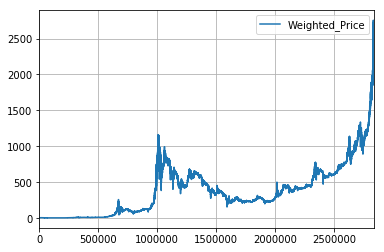

In [60]:
dataset[['Weighted_Price']].plot(grid=True)
plt.show()

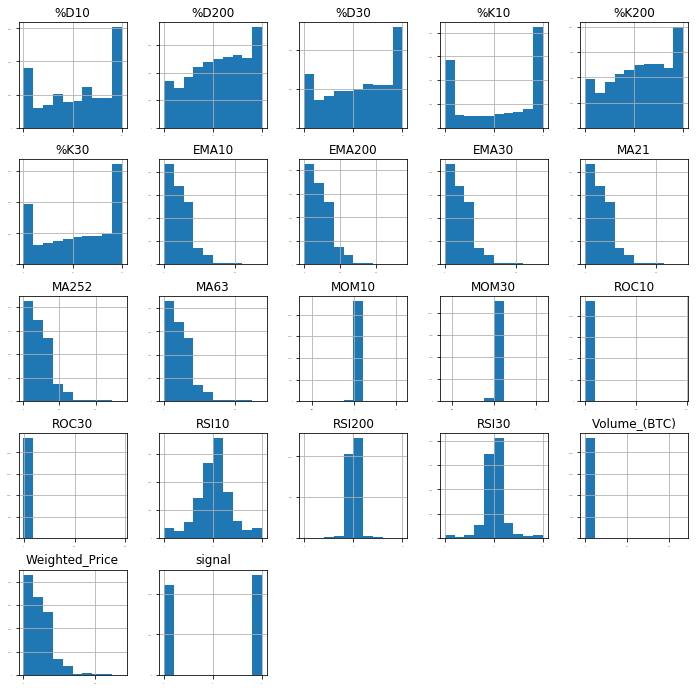

In [24]:
# histograms
dataset.hist(sharex=False, sharey=False, xlabelsize=1, ylabelsize=1, figsize=(12,12))
plt.show()

upward  52.87167614854236% out of 2342012 total datasize


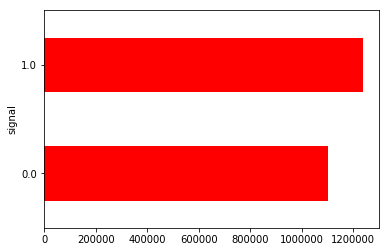

In [27]:
fig = plt.figure()
plot = dataset.groupby(['signal']).size().plot(kind='barh', color='red')
plt.show()

The predicted variable is upward 52.87% out of total data-size, meaning that number
of the buy signals were more than the number of sell signals. 

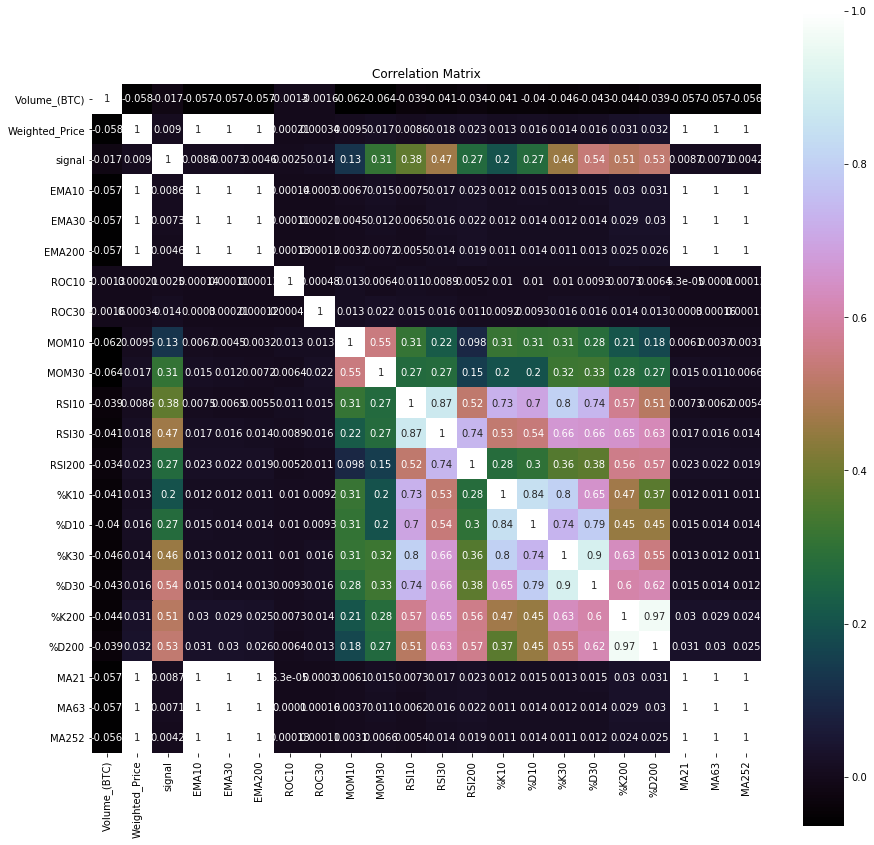

In [28]:
# correlation
correlation = dataset.corr()
plt.figure(figsize=(15,15))
plt.title('Correlation Matrix')
sns.heatmap(correlation, vmax=1, square=True,annot=True,cmap='cubehelix')

<a id='4'></a>
# 5. Evaluate Algorithms and Models

<a id='4.1'></a>
## 5.1. Train Test Split

We split the dataset into 80% training set and 20% test set.

In [103]:
# split out validation dataset for the end
subset_dataset= dataset.iloc[-100000:]
Y= subset_dataset["signal"]
X = subset_dataset.loc[:, dataset.columns != 'signal']
validation_size = 0.2
seed = 1
X_train, X_validation, Y_train, Y_validation = train_test_split(X, Y, test_size=validation_size, random_state=1)

<a id='4.2'></a>
## 5.2. Test Options and Evaluation Metrics


In [101]:
# test options for classification
num_folds = 10
seed = 7
scoring = 'accuracy'
#scoring = 'precision'
#scoring = 'recall'
#scoring ='neg_log_loss'
#scoring = 'roc_auc'

<a id='4.3'></a>
## 5.3. Compare Models and Algorithms

In order to know which algorithm technic is the best for our strategy, we evaluate following non linear different methods:

<a id='4.3.1'></a>
### 5.3.1. Models

In [113]:
# spot check the algorithms
models = []
models.append(('LR', LogisticRegression(n_jobs=-1)))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
#Neural Network
models.append(('NN', MLPClassifier()))
#Ensable Models 
# Boosting methods
models.append(('AB', AdaBoostClassifier()))
models.append(('GBM', GradientBoostingClassifier()))
# Bagging methods
models.append(('RF', RandomForestClassifier(n_jobs=-1)))

### K-folds cross validation

In [114]:
results = []
names = []
for name, model in models:
    kfold = KFold(n_splits=num_folds, random_state=seed)
    cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR: 0.955325 (0.003463)
LDA: 0.889112 (0.005189)
KNN: 0.869538 (0.003701)
CART: 0.895537 (0.002440)
NB: 0.789650 (0.004450)
NN: 0.842437 (0.042223)
AB: 0.896513 (0.003328)
GBM: 0.908988 (0.003471)
RF: 0.916100 (0.003465)


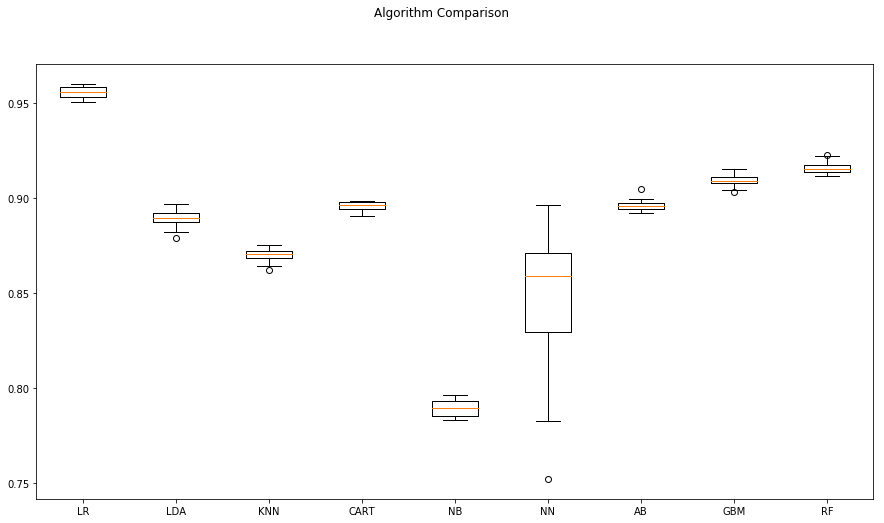

In [118]:
# compare algorithms
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
fig.set_size_inches(15,8)
plt.show()

<a id='5'></a>
# 6. Model Tuning and Grid Search

Random forest is selected for the grid search as it is one of the best models out of all.

In [120]:
# Grid Search: Random Forest Classifier
'''
n_estimators : int (default=100)
    The number of boosting stages to perform. 
    Gradient boosting is fairly robust to over-fitting so a large number usually results in better performance.
max_depth : integer, optional (default=3)
    maximum depth of the individual regression estimators. 
    The maximum depth limits the number of nodes in the tree. 
    Tune this parameter for best performance; the best value depends on the interaction of the input variables    
criterion : string, optional (default=”gini”)
    The function to measure the quality of a split. 
    Supported criteria are “gini” for the Gini impurity and “entropy” for the information gain. 
    
'''   
scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)
n_estimators = [20,80]
max_depth= [5,10]
criterion = ["gini","entropy"]
param_grid = dict(n_estimators=n_estimators, max_depth=max_depth, criterion = criterion )
model = RandomForestClassifier(n_jobs=-1)
kfold = KFold(n_splits=num_folds, random_state=seed)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(rescaledX, Y_train)

#Print Results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
ranks = grid_result.cv_results_['rank_test_score']
for mean, stdev, param, rank in zip(means, stds, params, ranks):
    print("#%d %f (%f) with: %r" % (rank, mean, stdev, param))

Best: 0.903438 using {'criterion': 'gini', 'max_depth': 10, 'n_estimators': 80}
#7 0.868487 (0.002811) with: {'criterion': 'gini', 'max_depth': 5, 'n_estimators': 20}
#5 0.870788 (0.002482) with: {'criterion': 'gini', 'max_depth': 5, 'n_estimators': 80}
#2 0.902900 (0.002600) with: {'criterion': 'gini', 'max_depth': 10, 'n_estimators': 20}
#1 0.903438 (0.003581) with: {'criterion': 'gini', 'max_depth': 10, 'n_estimators': 80}
#8 0.865300 (0.004989) with: {'criterion': 'entropy', 'max_depth': 5, 'n_estimators': 20}
#6 0.869950 (0.003233) with: {'criterion': 'entropy', 'max_depth': 5, 'n_estimators': 80}
#4 0.900088 (0.003467) with: {'criterion': 'entropy', 'max_depth': 10, 'n_estimators': 20}
#3 0.902438 (0.003209) with: {'criterion': 'entropy', 'max_depth': 10, 'n_estimators': 80}


<a id='6'></a>
# 7. Finalise the Model

Finalizing the model with best parameters found during tuning step.

<a id='6.1'></a>
## 7.1. Results on the Test Dataset

In [122]:
# prepare model
model = RandomForestClassifier(criterion='gini', n_estimators=80,max_depth=10,n_jobs=-1) # rbf is default kernel
#model = LogisticRegression() 
model.fit(X_train, Y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=10, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=80, n_jobs=-1,
                       oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [123]:
# estimate accuracy on validation set
predictions = model.predict(X_validation)
print(accuracy_score(Y_validation, predictions))
print(confusion_matrix(Y_validation, predictions))
print(classification_report(Y_validation, predictions))

0.9075
[[ 7852   966]
 [  884 10298]]
              precision    recall  f1-score   support

         0.0       0.90      0.89      0.89      8818
         1.0       0.91      0.92      0.92     11182

    accuracy                           0.91     20000
   macro avg       0.91      0.91      0.91     20000
weighted avg       0.91      0.91      0.91     20000



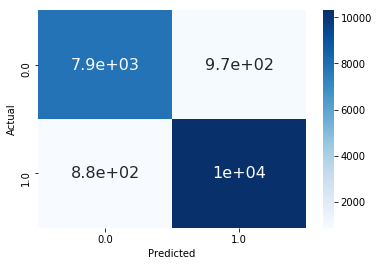

In [124]:
df_cm = pd.DataFrame(confusion_matrix(Y_validation, predictions), columns=np.unique(Y_validation), index = np.unique(Y_validation))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
sns.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16})# font sizes

<a id='6.2'></a>
## 7.2. Variable Intuition/Feature Importance
Let us look into the Feature Importance of the model

Text(0.5, 0, 'Variable Importance')

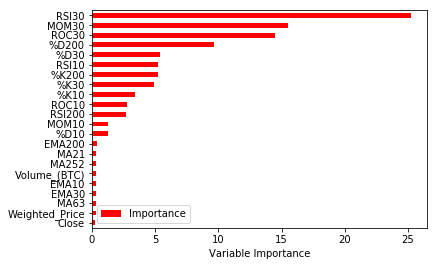

In [125]:
Importance = pd.DataFrame({'Importance':model.feature_importances_*100}, index=X.columns)
Importance.sort_values('Importance', axis=0, ascending=True).plot(kind='barh', color='r' )
plt.xlabel('Variable Importance')

<a id='7'></a>
## 8. Backtesting Results

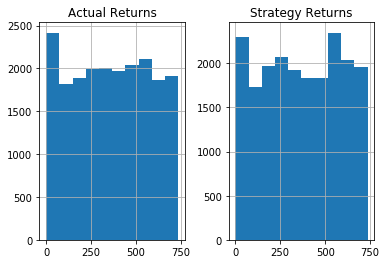

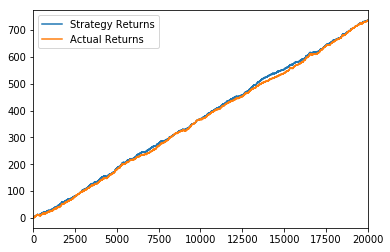

In [126]:
#Create column for Strategy Returns by multiplying the daily returns by the position that was held at close
#of business the previous day
backtestdata = pd.DataFrame(index=X_validation.index)
#backtestdata = pd.DataFrame()
backtestdata['signal_pred'] = predictions
backtestdata['signal_actual'] = Y_validation
backtestdata['Market Returns'] = X_validation['Close'].pct_change()
backtestdata['Actual Returns'] = backtestdata['Market Returns'] * backtestdata['signal_actual'].shift(1)
backtestdata['Strategy Returns'] = backtestdata['Market Returns'] * backtestdata['signal_pred'].shift(1)
backtestdata=backtestdata.reset_index()
backtestdata.head()
backtestdata[['Strategy Returns','Actual Returns']].cumsum().hist()
backtestdata[['Strategy Returns','Actual Returns']].cumsum().plot()

__Conclusion__:

We showed that framing the problem is the first priority and we address it by engi‐
neering the features and transforming the labels according to the investment objective.

We demonstrated the efficiency of using feature engineering that leads to creation of
intuitive features related to the trend and momentum of the price movement and
increases the predictive power of the model.

In terms of the evaluation metrics for a classification-based trading strategy, accuracy
or auc are appropriate, but in case the strategy is focusing to be more accurate while
going long, the metric recall which focuses on less false positive can be preferred as
compared to accuracy.

Finally, we demonstrated the backtesting framework which allows us to simulate a
trading strategy using historical data to generate results and analyze risk and profita‐
bility before risking any actual capital.
